# Civic Issue Priority Prediction

This notebook demonstrates a machine learning pipeline to classify **citizen complaints/issues** into **priority levels (Low, Medium, High)**.  
The model takes into account:
- **Short textual description** of the issue
- **Issue category**
- **Location type**

We use **TF-IDF for text features** and **OneHotEncoding for categorical variables**, combined in a **Logistic Regression classifier**.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

## 2. Load Dataset
We use a dummy dataset (`Dummy_DataSet.csv`) stored in `data/raw/`.


In [4]:
df = pd.read_csv('data/raw/Dummy_DataSet.csv')
df.head()

,short_description,category,location,admin_priority
0,Complaint: road condition unsafe in school,road,school,High
1,Complaint: can be checked water supply problem...,water,hospital,Low
2,"Broken bench found in park at highway, not severe",park,highway,Low
3,"Park is dirty near residential, problematic",park,residential,Medium
4,Complaint: garbage issue creating disturbance ...,garbage,hospital,Low


## 3. Basic Data Check
Before modeling, let's check:
- Data shape
- Missing values
- Class distribution of target (`admin_priority`)


In [5]:
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nTarget Distribution:\n", df['admin_priority'].value_counts())


Dataset Shape: (480, 4)

Missing Values:
 short_description    0
category             0
location             0
admin_priority       0
dtype: int64

Target Distribution:
 admin_priority
High      160
Low       160
Medium    160
Name: count, dtype: int64



# Plot target distribution


C:\Users\SHAHID\AppData\Local\Temp\ipykernel_10244\3765216784.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="admin_priority", palette="Set2")


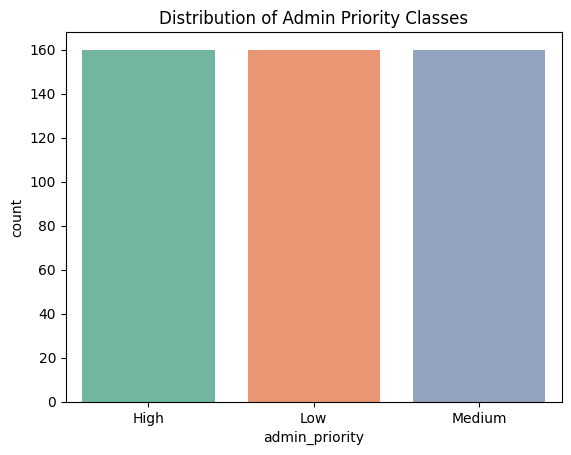

In [6]:
sns.countplot(data=df, x="admin_priority", palette="Set2")
plt.title("Distribution of Admin Priority Classes")
plt.show()


## 4. Feature & Target Selection
We will use:
- `short_description` (text)
- `category` (categorical)
- `location` (categorical)

Target: `admin_priority`


In [7]:
# Features & Target
X = df[["short_description", "category", "location"]]
y = df["admin_priority"]

# Encode Target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


## 5. Preprocessing & Pipeline
- **TF-IDF Vectorizer** for text
- **One-Hot Encoding** for category & location
- **Logistic Regression** for classification


In [8]:
# Transformers
text_transformer = TfidfVectorizer(stop_words="english")
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [ ]:
# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, "short_description"),
        ("cat", categorical_transformer, ["category", "location"])
    ]
)

In [10]:
# Pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

## 6. Train-Test Split


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)


## 7. Model Training & Evaluation


In [12]:
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'short_description'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'location'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [13]:
# Predictions
y_pred = model.predict(X_test)

In [16]:
# Accuracy
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))


Accuracy: 0.889


In [18]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



Classification Report:
              precision    recall  f1-score   support

        High       0.81      0.90      0.85        48
         Low       0.92      0.92      0.92        48
      Medium       0.95      0.85      0.90        48

    accuracy                           0.89       144
   macro avg       0.89      0.89      0.89       144
weighted avg       0.89      0.89      0.89       144



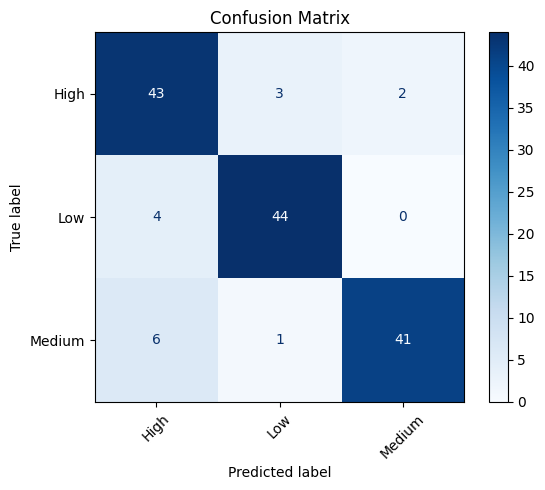

In [19]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=label_encoder.classes_, cmap="Blues", xticks_rotation=45
)
plt.title("Confusion Matrix")
plt.show()

## 8. Inference on New Complaints
Let's test on unseen complaints.


In [20]:
new_complaints = pd.DataFrame([
    {"short_description": "Broken traffic signal causing accidents", 
     "category": "safety", 
     "location": "highway"},
    
    {"short_description": "Overflowing garbage in market area", 
     "category": "garbage", 
     "location": "residential"}
])


In [21]:
# Predict
predictions = model.predict(new_complaints)
predicted_labels = label_encoder.inverse_transform(predictions)


In [22]:
# Show Results
for text, label in zip(new_complaints["short_description"], predicted_labels):
    print(f"Issue: {text} → Predicted Priority: {label}")

Issue: Broken traffic signal causing accidents → Predicted Priority: Medium
Issue: Overflowing garbage in market area → Predicted Priority: High


# Summary
- Achieved **~90% accuracy** on dummy dataset.
- Balanced performance across classes (Low, Medium, High).
- Pipeline integrates text + categorical features smoothly.
- Ready to be integrated with Flask backend for real-time issue prioritization.

### Next Steps:
- Collect real-world labeled complaint data.
- Experiment with advanced models (RandomForest, XGBoost, BERT for text).
- Deploy trained model in `src/pipeline/predict_pipeline.py`.
